# First-price hybrid simulations

In [181]:
import numpy as np
import seaborn as sns
import pandas as pd
from collections import defaultdict
from itertools import product
rng = np.random.default_rng()

## Main loop

- `values`: Willingness-to-pay of each bidder 
- `increment`: By how much new bids must outbid the $k$-th bid
- `transaction_cost`: Price of a transaction (USD)
- `reserve_price`: Reserve price (USD)
- `k`: Tickets in the auction
- `m`: Tickets in the lottery
- `lottery`: Boolean, represents whether bidders estimate their chances to win in the lottery when computing their expected payoff from the bid

In [182]:
def run_simulation(values, increment=10, transaction_cost=5, reserve_price=1000, k=20, m=80, lottery=False, log=False):
    bids = {}
    transactions_per_user = defaultdict(int)
    last_bid = 0
    N = len(values)

    while last_bid < 2 * N:
        bidder = rng.integers(0, N)

        if len(bids) <= k:
            if not bidder in bids:
                # First bid of user
                bids[bidder] = reserve_price
                transactions_per_user[bidder] += 1
                last_bid = 0
                if log: print(f"Bidder {bidder} places their first bid", sorted(bids.items(), key=lambda x: x[0]))
            else:
                # Opportunity to update rejected, auction not competitive yet
                last_bid += 1
            continue
            
        kth_bid = sorted(bids.values(), reverse=True)[k-1]
        kplus_bid = sorted(bids.values(), reverse=True)[k]

        # Bidder is still competitive
        if bidder in bids and kplus_bid < bids[bidder]:
            if log: print(f"Bidder {bidder} is still competitive")
            last_bid += 1
            continue

        # Auction is too competitive for the bidder
        expected_lottery_reward = float(m) / (len(bids)-k) * (values[bidder] - reserve_price) if len(bids) > k+m else (values[bidder] - reserve_price)
        if values[bidder] - (kth_bid + increment + transaction_cost) < lottery * expected_lottery_reward:
            # If the bidder hasn't bid yet
            if not bidder in bids:
                bids[bidder] = reserve_price
                transactions_per_user[bidder] += 1
                last_bid = 0
                if log: print(f"Bidder {bidder} places their first bid", sorted(bids.items(), key=lambda x: x[0]))
            else:
                last_bid += 1
            continue

        # Bidder wants to remain competitive
        bids[bidder] = kth_bid + increment
        transactions_per_user[bidder] += 1
        last_bid = 0
        if log: print(f"Bidder {bidder} outbids", sorted(bids.items(), key=lambda x: x[0]))
        
    return (bids, transactions_per_user)

In [183]:
N = 200
reserve_price = 1000
increments = np.arange(5, 55, 5)
transaction_costs = np.arange(5, 55, 5)
lotteries = [True, False]
stats = []
for (tx_cost, increment, lottery) in product(transaction_costs, increments, lotteries):
    run_stats = []
    for run in range(50):
        values = [reserve_price + rng.pareto(2) * reserve_price / 5 for i in range(N)]
        bids, txs_per_user = run_simulation(values, increment=increment, lottery=True)
        single_txs = len([tx for tx in txs_per_user.values() if tx == 1])
        max_txs = max(txs_per_user.values())
        n_txs = sum(txs_per_user.values())
        run_stats += [{ "single_txs": single_txs, "n_txs": n_txs, "max_txs": max_txs }]
    stats += [{
        "tx_cost": tx_cost, "increment": increment,
        "avg_tx_number": np.mean([s["n_txs"] for s in run_stats]),
        "avg_max_tx_number": np.mean([s["max_txs"] for s in run_stats]),
        "avg_single_txs": np.mean([s["single_txs"] for s in run_stats]),
        "lottery": lottery
    }]
stats = pd.DataFrame(stats)

In [184]:
pd.set_option('display.max_rows', 20)
stats

,tx_cost,increment,avg_tx_number,avg_max_tx_number,avg_single_txs,lottery
0,5,5,1077.52,28.36,101.40,True
1,5,5,1083.80,28.52,100.06,False
2,5,10,622.94,16.10,124.30,True
3,5,10,626.20,16.06,124.72,False
4,5,15,485.36,12.60,135.94,True
...,...,...,...,...,...,...
195,50,40,305.86,6.48,159.26,False
196,50,45,292.26,6.10,161.20,True
197,50,45,286.32,5.86,162.22,False
198,50,50,282.54,5.62,163.44,True


#### A typical `values` distribution

array([[<AxesSubplot:title={'center':'values'}>]], dtype=object)

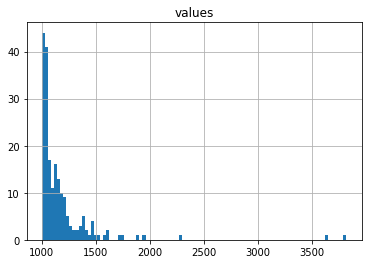

In [185]:
rng = np.random.default_rng(42)
values = [reserve_price + rng.pareto(2) * reserve_price / 5 for i in range(N)]
pd.DataFrame({ "values": values }).hist(bins=100)

#### Estimated average number of transactions per increment (with and without lottery estimation)

<AxesSubplot:xlabel='increment', ylabel='avg_tx_number'>

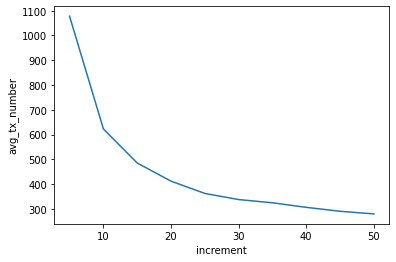

In [186]:
sns.lineplot(data=stats[(stats.tx_cost == 5) & (stats.lottery)], x="increment", y="avg_tx_number")

#### The bids stop at (or close) to the (k+1)-th highest value!

When `lottery == False`.

In [187]:
N = 200
rng = np.random.default_rng(42)

values = [reserve_price + rng.pareto(2) * reserve_price / 5 for i in range(N)]
bids, txs_per_user = run_simulation(values, transaction_cost=10, increment=10, lottery=False)
print(f"k-th highest bid = {sorted(bids.values(), reverse=True)[k-1]}, (k+1)-th highest value = {sorted(values, reverse=True)[k]}")

k-th highest bid = 1370, (k+1)-th highest value = 1384.5112678643395


When `lottery == True`, bidders discount the benefit of winning the auction by their likelihood to win the lottery, so the bids are smaller.

In [188]:
rng = np.random.default_rng(42)
values = [reserve_price + rng.pareto(2) * reserve_price / 5 for i in range(N)]
bids, txs_per_user = run_simulation(values, transaction_cost=10, increment=10, lottery=True)
print(f"k-th highest bid = {sorted(bids.values(), reverse=True)[k-1]}, (k+1)-th highest value = {sorted(values, reverse=True)[k]}")

k-th highest bid = 1200, (k+1)-th highest value = 1384.5112678643395


In [189]:
print(sorted(bids.values(), reverse=True))

[1210, 1210, 1210, 1210, 1210, 1210, 1210, 1210, 1210, 1210, 1210, 1210, 1210, 1210, 1210, 1210, 1210, 1210, 1210, 1200, 1200, 1200, 1200, 1190, 1190, 1180, 1180, 1160, 1160, 1150, 1150, 1140, 1130, 1130, 1120, 1110, 1110, 1110, 1100, 1100, 1100, 1090, 1090, 1090, 1090, 1080, 1080, 1080, 1080, 1070, 1070, 1070, 1070, 1070, 1070, 1060, 1060, 1060, 1060, 1060, 1060, 1060, 1050, 1050, 1050, 1050, 1040, 1040, 1040, 1040, 1040, 1030, 1030, 1030, 1030, 1030, 1020, 1020, 1020, 1010, 1010, 1010, 1010, 1010, 1010, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 100

In [190]:
N = 3
rng = np.random.default_rng(4)
values = [reserve_price + rng.pareto(2) * reserve_price / 5 for i in range(N)]
print(values)
run_simulation(values, transaction_cost=5, increment=10, lottery=False, k = 2, m = 0, log=True)

[2136.3946374918605, 1048.0714339360236, 1810.7187271382188]
Bidder 2 places their first bid [(2, 1000)]
Bidder 0 places their first bid [(0, 1000), (2, 1000)]
Bidder 1 places their first bid [(0, 1000), (1, 1000), (2, 1000)]
Bidder 1 outbids [(0, 1000), (1, 1010), (2, 1000)]
Bidder 0 outbids [(0, 1010), (1, 1010), (2, 1000)]
Bidder 1 is still competitive
Bidder 1 is still competitive
Bidder 2 outbids [(0, 1010), (1, 1010), (2, 1020)]
Bidder 1 outbids [(0, 1010), (1, 1020), (2, 1020)]
Bidder 0 outbids [(0, 1030), (1, 1020), (2, 1020)]
Bidder 2 outbids [(0, 1030), (1, 1020), (2, 1030)]
Bidder 2 is still competitive
Bidder 0 is still competitive
Bidder 1 outbids [(0, 1030), (1, 1040), (2, 1030)]
Bidder 1 is still competitive
Bidder 2 outbids [(0, 1030), (1, 1040), (2, 1040)]
Bidder 0 outbids [(0, 1050), (1, 1040), (2, 1040)]
Bidder 2 outbids [(0, 1050), (1, 1040), (2, 1050)]
Bidder 0 is still competitive
Bidder 2 is still competitive
Bidder 2 is still competitive
Bidder 2 is still compet

({2: 1050, 0: 1050, 1: 1040}, defaultdict(int, {2: 5, 0: 4, 1: 4}))

#### A small calculator for transaction costs

In [191]:
gas_needed = 250000
gas_price_gwei = 50
eth_price = 1000
bid_cost_eth = gas_needed * gas_price_gwei / 1e9
bid_cost_usd = bid_cost_eth * eth_price
bid_cost_usd

12.5